In [1]:
!pip install scikit-learn-extra


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import TimeSeriesKMeans
from sklearn_extra.cluster import KMedoids
from tslearn.metrics import soft_dtw

In [23]:

df_temp_out = pd.read_csv('outdoor_temperature.csv')  
df_office = pd.read_csv('office_consumption.csv')
df_temp_in= pd.read_csv('indoor_temperature.csv')  
df_heat = pd.read_csv('heating_consumption.csv')  
df_cool = pd.read_csv('cooling_consumption.csv')  



In [78]:


dfs = [df_temp_out, df_office, df_temp_in, df_heat, df_cool]

data_stack = np.stack([df.values for df in dfs])
data_median = np.median(data_stack, axis=0)  
df_median = pd.DataFrame(data_median, columns=df_temp_out.columns)

print(df_median.head())


   5.2000  4.2000  4.4000  3.3000  1.7000  2.8000  1.9000  1.9000.1  2.0000  \
0   0.078   0.078   0.078   0.077   0.000   0.000   0.000     0.000   0.000   
1   0.077   0.079   0.078   0.078   0.083   0.085   0.083     0.000   0.084   
2   0.077   0.078   0.078   0.078   0.083   0.084   0.084     0.382   0.800   
3   0.098   0.097   0.097   0.097   0.103   0.189   0.694     0.900   1.100   
4   0.154   0.154   0.154   0.153   0.156   0.152   1.500     1.400   1.333   

   2.3000  ...  3.1000.1  3.1000.2  2.6000.1  2.0000.1  1.2000  0.6000  \
0   0.000  ...     0.084     0.084     0.083     0.078   0.078   0.078   
1   0.084  ...     0.084     0.085     0.083     0.078   0.078   0.078   
2   0.764  ...     0.676     0.705     0.588     0.407   0.213   0.097   
3   0.611  ...     0.620     0.823     0.808     0.396   0.159   0.155   
4   1.548  ...     0.639     0.704     0.653     0.301   0.196   0.182   

   0.1000  0.7000  1.1000  0.9000  
0   0.078   0.080   0.079   0.082  
1   0.07

In [79]:

scaler = TimeSeriesScalerMeanVariance()
data_normalized3 = scaler.fit_transform(df_median.values.reshape((df_median.shape[0], df_median.shape[1], 1)))  
data_scaled2 = pd.DataFrame(data_normalized3.reshape(data_normalized3.shape[0], data_normalized3.shape[1]), columns=df_median.columns)
print( data_scaled2)



       5.2000    4.2000    4.4000    3.3000    1.7000    2.8000    1.9000  \
0    0.518644  0.518644  0.518644  0.489830 -1.728812 -1.728812 -1.728812   
1   -0.033057  0.088999  0.027971  0.027971  0.333111  0.455167  0.333111   
2   -0.944518 -0.940966 -0.940966 -0.940966 -0.923206 -0.919654 -0.919654   
3   -1.020531 -1.023592 -1.023592 -1.023592 -1.005225 -0.741961  0.803950   
4   -0.740384 -0.740384 -0.740384 -0.742243 -0.736665 -0.744102  1.762217   
..        ...       ...       ...       ...       ...       ...       ...   
722  0.853518  0.853518  1.112815  0.853518  0.853518  0.853518  0.853518   
723  0.910879  0.910879  1.174265  0.910879  0.910879  0.910879  0.910879   
724  1.170289  0.640347  1.170289  1.170289  0.905318  0.905318  0.905318   
725  0.932643  0.932643  0.932643  1.199112  0.932643  0.932643  0.666173   
726  0.913523  0.913523  0.649372  0.913523  0.913523  0.913523  0.913523   

     1.9000.1    2.0000    2.3000  ...  3.1000.1  3.1000.2  2.6000.1  \
0  

In [83]:

kmeans_dtw = TimeSeriesKMeans(n_clusters=4, metric="dtw", random_state=42)
data_scaled2['cluster'] = kmeans_dtw.fit_predict(data_scaled2)



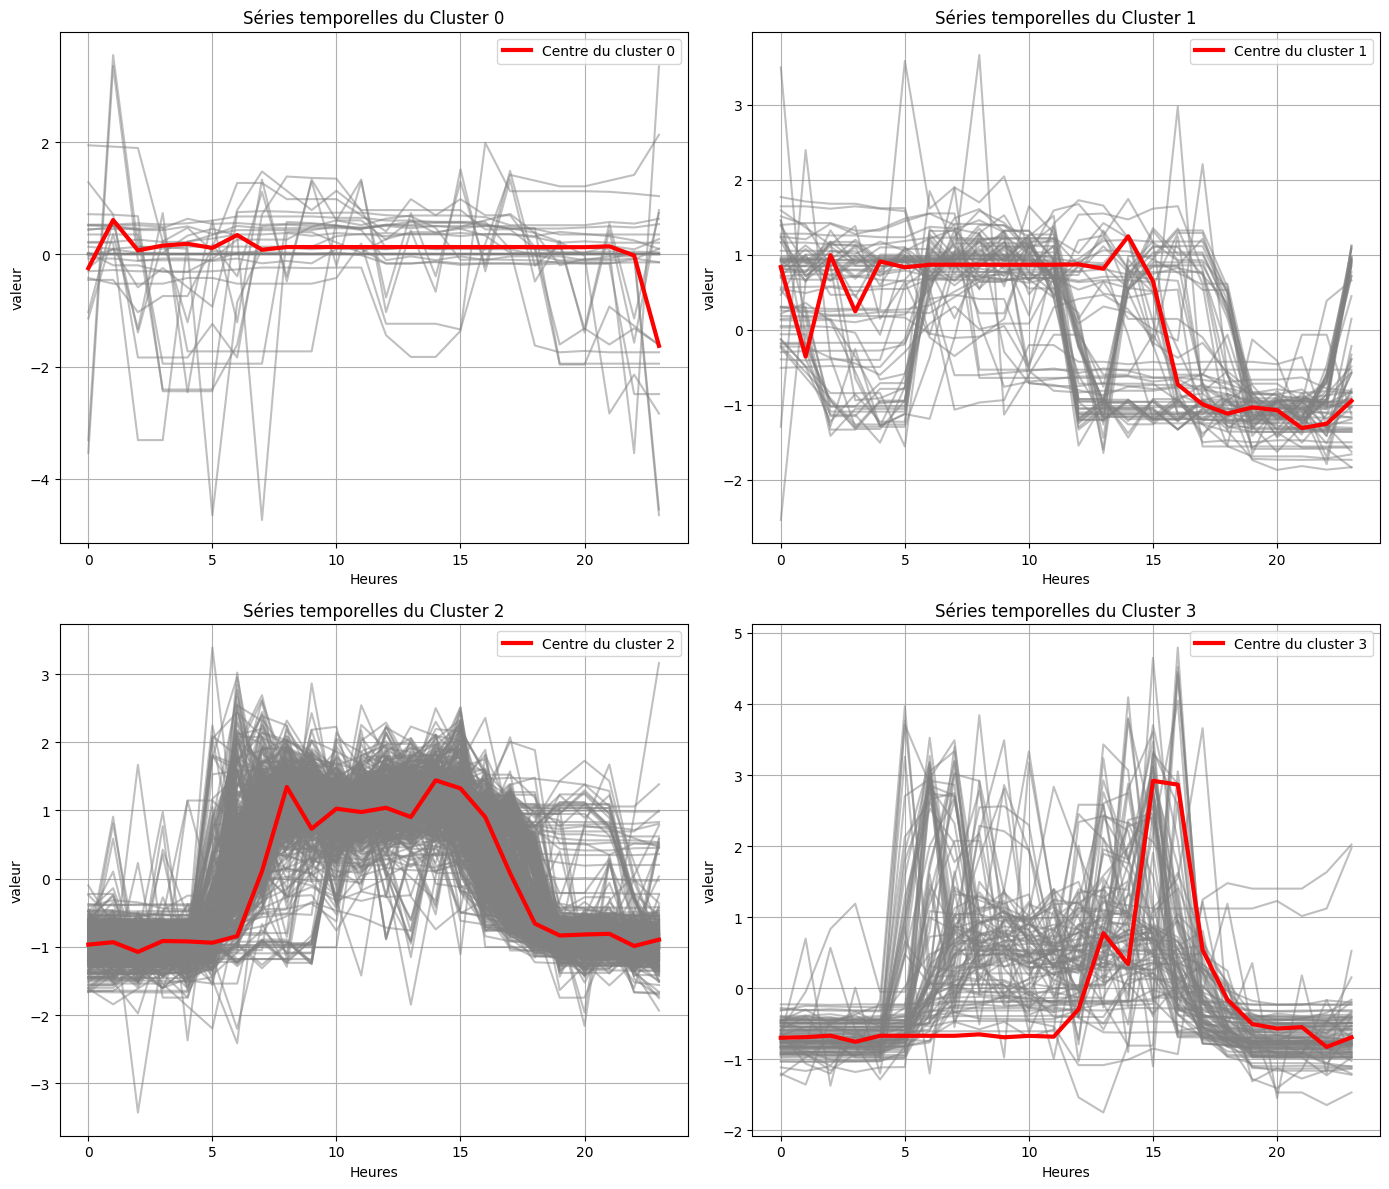

In [86]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for cluster_id in range(kmeans_dtw.n_clusters):
    cluster_data = data_scaled2[data_scaled2['cluster'] == cluster_id]

    for idx, row in cluster_data.iterrows():
        # Exclure la colonne 'cluster' qui est la dernière colonne
        axes[cluster_id // 2, cluster_id % 2].plot(range(24), row.iloc[:-1].values, color='gray', alpha=0.5)

    # Récupérer le centre du cluster et exclure la colonne 'cluster'
    cluster_center = kmeans_dtw.cluster_centers_[cluster_id][:-1]

    axes[cluster_id // 2, cluster_id % 2].plot(range(24), cluster_center, color='red', linewidth=3, label=f"Centre du cluster {cluster_id}")

    axes[cluster_id // 2, cluster_id % 2].set_title(f"Séries temporelles du Cluster {cluster_id}")
    axes[cluster_id // 2, cluster_id % 2].set_xlabel("Heures")
    axes[cluster_id // 2, cluster_id % 2].set_ylabel("valeur")
    axes[cluster_id // 2, cluster_id % 2].grid(True)

    # Ajouter la légende pour le centre du cluster
    axes[cluster_id // 2, cluster_id % 2].legend(loc='upper right')

# Masquer l'axe inutilisé si nécessaire
if kmeans_dtw.n_clusters < 4:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [87]:
if df_office.shape[0] == df_heat.shape[0] == df_cool.shape[0]:
    df_consumption = pd.DataFrame()

    for col_office, col_heat, col_cool in zip(df_office.columns, df_heat.columns, df_cool.columns):
        df_consumption[col_office] = (df_office[col_office] + df_heat[col_heat] + df_cool[col_cool]) 

    print(df_consumption)
else:
    print("Les DataFrames n'ont pas le même nombre de lignes.")

     0.0000  0.0780  0.0780.1  0.0780.2  0.0840  0.0840.1  0.0840.2  0.0840.3  \
0     0.078   0.078     0.078     0.077   0.084     0.084     0.084     0.084   
1     0.077   0.079     0.078     0.078   0.083     0.085     0.083     0.084   
2     0.077   0.078     0.078     0.078   0.083     0.682     1.010     2.907   
3     0.098   0.097     0.097     0.097   0.103     0.292     0.797     2.547   
4     0.154   0.154     0.154     0.153   0.156     0.304     1.945     2.116   
..      ...     ...       ...       ...     ...       ...       ...       ...   
722   0.149   0.149     0.150     0.149   0.149     0.149     0.149     0.149   
723   0.149   0.149     0.150     0.149   0.149     0.149     0.149     0.148   
724   0.150   0.148     0.150     0.150   0.149     0.149     0.149     0.149   
725   0.149   0.149     0.149     0.150   0.149     0.149     0.148     0.148   
726   0.149   0.149     0.148     0.149   0.149     0.149     0.149     0.149   

     0.0840.4  0.0840.5  ..

In [88]:

scaler = TimeSeriesScalerMeanVariance()
data_normalized3 = scaler.fit_transform(df_consumption.values.reshape((df.shape[0], df.shape[1], 1)))  
data_scaled = pd.DataFrame(data_normalized3.reshape(data_normalized3.shape[0], data_normalized3.shape[1]), columns=df_consumption.columns)
print( data_scaled)

scaler = TimeSeriesScalerMeanVariance()
data_normalized3 = scaler.fit_transform(df_consumption.values.reshape((df_consumption.shape[0], df_consumption.shape[1], 1)))

data_scaled = pd.DataFrame(data_normalized3.reshape(data_normalized3.shape[0], data_normalized3.shape[1]), columns=df_consumption.columns)


       0.0000    0.0780  0.0780.1  0.0780.2    0.0840  0.0840.1  0.0840.2  \
0   -1.095684 -1.095684 -1.095684 -1.466056  1.126549  1.126549  1.126549   
1   -1.480097 -0.747678 -1.113887 -1.113887  0.717160  1.449579  0.717160   
2   -0.776016 -0.774657 -0.774657 -0.774657 -0.767862  0.046148  0.491883   
3   -0.917957 -0.919359 -0.919359 -0.919359 -0.910944 -0.645866  0.062413   
4   -0.856219 -0.856219 -0.856219 -0.857583 -0.853491 -0.651586  1.587100   
..        ...       ...       ...       ...       ...       ...       ...   
722  0.853518  0.853518  1.112815  0.853518  0.853518  0.853518  0.853518   
723  0.910879  0.910879  1.174265  0.910879  0.910879  0.910879  0.910879   
724  1.170289  0.640347  1.170289  1.170289  0.905318  0.905318  0.905318   
725  0.932643  0.932643  0.932643  1.199112  0.932643  0.932643  0.666173   
726  0.913523  0.913523  0.649372  0.913523  0.913523  0.913523  0.913523   

     0.0840.3  0.0840.4  0.0840.5  ...    0.0850    0.0830  0.0830.1  \
0  

In [93]:

kmeans_dtw = TimeSeriesKMeans(n_clusters=4, metric="dtw", random_state=42)
data_scaled['cluster'] = kmeans_dtw.fit_predict(data_scaled)



In [90]:
print("Centres des clusters:")
for cluster_id in range(kmeans_dtw.n_clusters):
    cluster_center = kmeans_dtw.cluster_centers_[cluster_id]
    print(f"Centre du cluster {cluster_id}: {cluster_center.flatten()}")


Centres des clusters:
Centre du cluster 0: [-0.69956851 -0.02316814 -0.2801701  -0.18799954 -0.18328732 -0.18324719
 -0.18318586 -0.18863166 -0.18694045 -0.18604944 -0.18681962 -0.17979416
 -0.1848909   0.3691306   0.02357287  0.21060046  2.1407567   0.21369814
 -0.3483637  -0.38870663 -0.31904804 -0.42562335 -0.68851474 -0.52587707]
Centre du cluster 1: [-0.83594625 -0.95822247 -0.91109744 -1.00595622 -0.90229413 -0.90151253
 -0.35363561  0.88203864  1.60377082  1.01217409  0.6083259   0.90658238
  0.87991397  0.93496409  0.83337607  1.31082403  0.27773205 -0.63067923
 -0.86913036 -0.8904562  -0.8673578  -0.87097974 -0.85525442 -1.02190039]
Centre du cluster 2: [ 1.01202652  0.70112338  0.64918605  0.73071791  0.5866758   0.9075542
  1.01398235  0.86954452  0.9639316   0.60666065  0.92075711  0.86688957
  0.78654658  1.1895613   0.42183089 -0.78927412 -0.97399422 -0.94952768
 -1.02496699 -1.12798465 -0.98698569 -1.29994644 -1.0546294  -0.1467496 ]
Centre du cluster 3: [-1.01706026 -1.

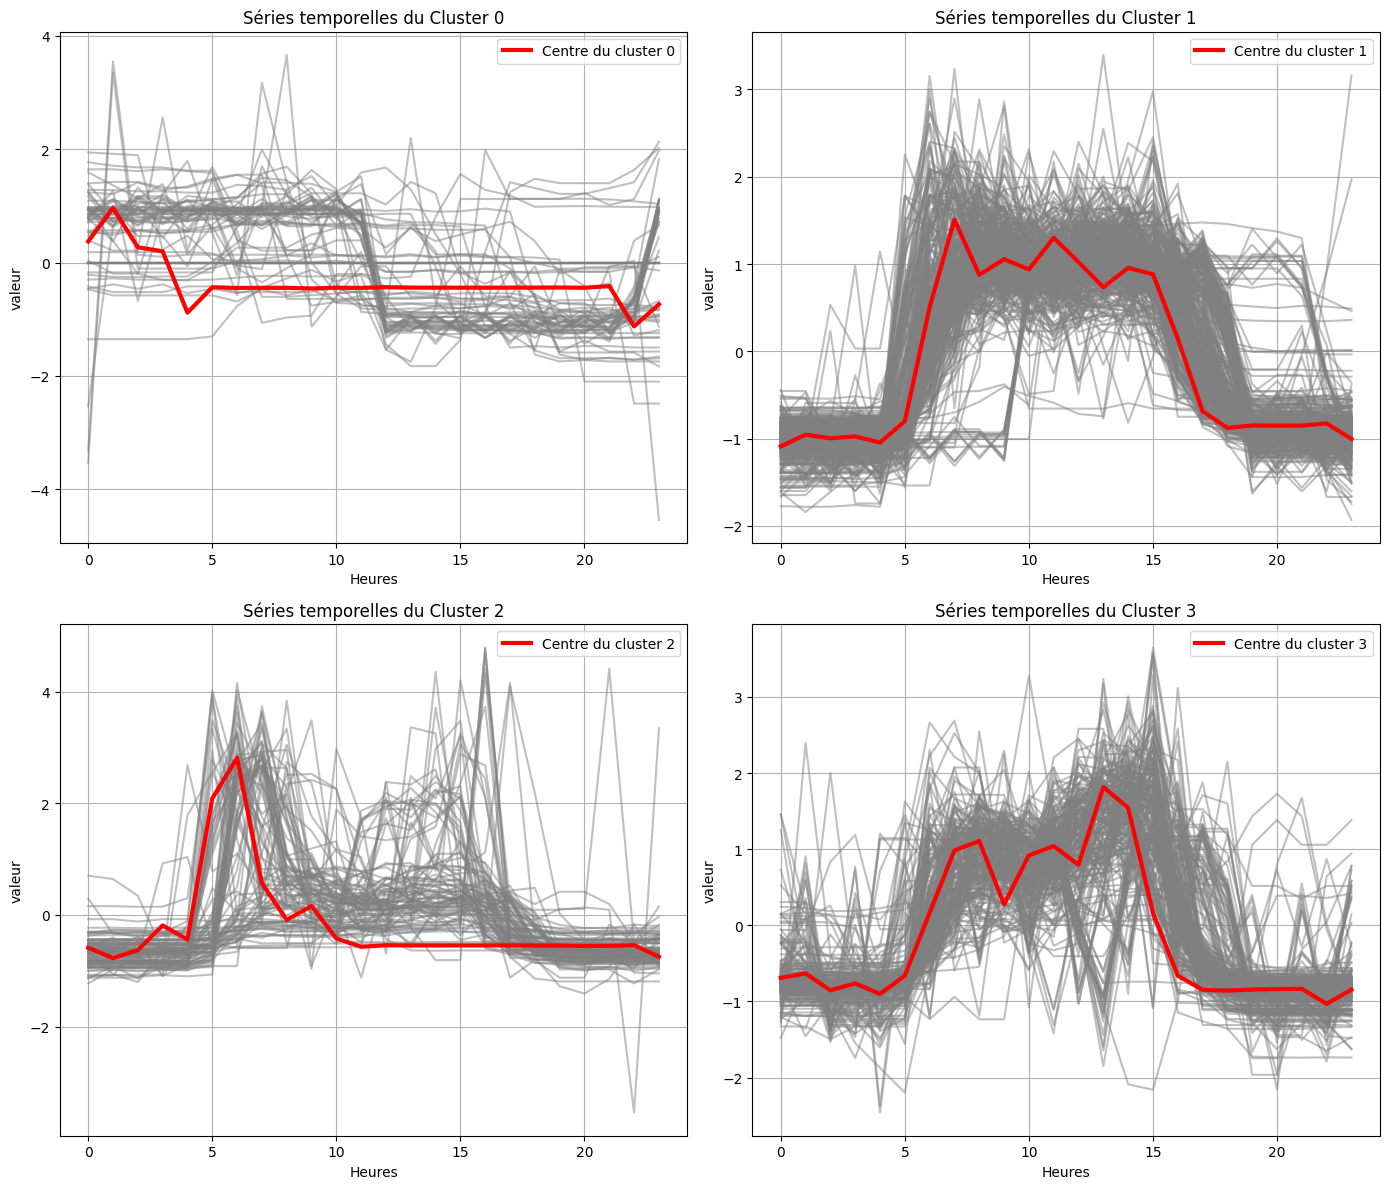

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for cluster_id in range(kmeans_dtw.n_clusters):
    cluster_data = data_scaled[data_scaled['cluster'] == cluster_id]

    for idx, row in cluster_data.iterrows():
        axes[cluster_id // 2, cluster_id % 2].plot(range(24), row.iloc[:-1].values, color='gray', alpha=0.5)

    cluster_center = kmeans_dtw.cluster_centers_[cluster_id][:-1]

    axes[cluster_id // 2, cluster_id % 2].plot(range(24), cluster_center, color='red', linewidth=3, label=f"Centre du cluster {cluster_id}")

    axes[cluster_id // 2, cluster_id % 2].set_title(f"Séries temporelles du Cluster {cluster_id}")
    axes[cluster_id // 2, cluster_id % 2].set_xlabel("Heures")
    axes[cluster_id // 2, cluster_id % 2].set_ylabel("valeur")
    axes[cluster_id // 2, cluster_id % 2].grid(True)

    axes[cluster_id // 2, cluster_id % 2].legend(loc='upper right')

if kmeans_dtw.n_clusters < 4:
    axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
